In [4]:
#Bibliotecas
!git clone https://github.com/FelipeFernandes1/minhas_funcoes
from minhas_funcoes.pacote_aed import *
from IPython.display import display
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

Cloning into 'minhas_funcoes'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 136 (delta 12), reused 5 (delta 5), pack-reused 106
Receiving objects: 100% (136/136), 41.55 KiB | 10.39 MiB/s, done.
Resolving deltas: 100% (47/47), done.


# Enquadrando o problema

## Contexto

O aplicativo ToComFome é um app de entrega de comida por delivery. Como todo aplicativo de varejo, a empresa se preocupa com o Churn de clientes, ou seja, da perda desse cliente para a concorrência. Para entender o perfil de risco do cliente com maior chance de churn, a área de CRM pediu um projeto para a área de Data Analytics para entender e classificar o cliente com risco de trocar de aplicativo nos próximos meses.

Para isso, a área de CRM passou uma amostra de cerca de 10 mil clientes com suas respectivas informações de cadastro e transações nos próximos 4 meses a contar da data de extração usada como referência.

##Proposta de solução

Criar um modelo preditivo capaz de classificar o usuário antes de apresentar o churn, para que seja possível agir antecipadamente de forma a retê-lo, utilizando a estratégia de cupons de desconto.

## Objetivos

1 - Criar um modelo de classificação

2 - Mensurar o potencial financeiro do modelo proposto

## <font color="yellow">Premissas

- Trata-se de uma amostra sem viés
- O churn é definido pelo fato da falta de transações nos últimos 30 dias, tendo como referência o último dia do período de 4 meses
- Ao receber um cupom de desconto, o cliente irá utilizá-lo e isso será o suficiente para retê-lo
- Para o próximo período o usuário manterá seu padrão de volume nas compras(Sum_Pedidos_Acumulados)
- Variáveis relacionadas ao crédito dos usuários foram adquiridas através de um bureau de crédito
- Por haver apenas uma data de extração, não será possível realizar a validação do modelo considerando a ordem cronológica(validação out of time)
- O tamanho(pequeno) do conjunto de dados não é o ideal para o aprendizado de máquina
- Para realizar o cálculo do potencial financeiro foi necessário assumir alguns valores(no mundo real essa informação poderia ser fornecida pelo time de Marketing):
LTV= média da variável "Sum_Pedidos_Acumulados"; CAC= 150; Custo cupom= 100
- Cálculo para verdadeiro positivo/falso positivo > qtd * (ltv - cac - cupom)
- Cálculo para falso negativo > qtd * cac
- Cálculo para verdadeiro negativo > qtd * (ltv - cac)
- Fórmula resultado > VP + VN + FP - FN

#Coleta e descrição dos dados

In [5]:
#Importando as tabelas
df_cliente = pd.read_csv('/content/clientes.csv')
df_churn = pd.read_csv('/content/churn.csv')
df_dicionario_cliente = pd.read_excel('/content/Metadados.xlsx', sheet_name='clientes')
df_dicionario_churn = pd.read_excel('/content/Metadados.xlsx', sheet_name='churn')

In [6]:
#Analisando a descrição dos dados da tabela cliente
df_dicionario_cliente

,Variavel,Descricao
0,ClientId,Identificador de cliente (campo PK)
1,DataExtracao,Data da extração dessa visão de clientes (foto)
2,Score_Credito,Score de Crédito no mercado
3,Estado,Estado do cliente
4,Gênero,Genero do cliente
5,Idade,Idade do cliente
6,Tempo_Cliente,Tempo em meses em que o cliente utiliza o aplicativo
7,Limite_Credito_Mercado,Limite de Crédito que o cliente tem no mercado.
8,Qte_Categorias,"Qte de categorias de produtos (ex: lanches, comida japonesa, doces etc) pedidos nos ultimos 3 meses anteriores à data de extração."
9,Usa_Cartao_Credito,Flag se cliente cadastrou um cartão de crédito no aplicativo. 1 = Cadastrou e 0 = Não Cadastrou


In [7]:
#Analisando a descrição dos dados da tabela churn
df_dicionario_churn

,Variavel,Descricao
0,ClientId,Identificador de cliente (campo PK)
1,DataUltimaTransacao,A data da última transação realizada por cada cliente


In [8]:
#Verificando se o período de fato corresponde a 4 meses
df_churn['DataUltimaTransacao'] = pd.to_datetime(df_churn['DataUltimaTransacao'])
df_cliente['DataExtracao'] = pd.to_datetime(df_cliente['DataExtracao'])

df_churn['DataUltimaTransacao'].max() - df_cliente['DataExtracao'][0]

Timedelta('122 days 00:00:00')

In [9]:
#Unindo as tabelas
df = pd.merge(df_cliente, df_churn[['ClientId', 'DataUltimaTransacao']], on='ClientId', how='left')

In [10]:
#Criando a coluna Churn=1
df['Dias'] =  (df['DataUltimaTransacao'].max() - df['DataUltimaTransacao']).dt.days
df['Churn'] = 0
df.loc[df['Dias'] > 30, 'Churn'] = 1

In [11]:
#Excluindo as colunas desnecessarias(utilizadas somente para classificar o churn)
df = df.drop(['DataExtracao','DataUltimaTransacao','Dias'], axis=1)

In [12]:
#Analisando a estrutura
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ClientId                10000 non-null  int64  
 1   Score_Credito           10000 non-null  int64  
 2   Estado                  10000 non-null  object 
 3   Gênero                  10000 non-null  object 
 4   Idade                   10000 non-null  int64  
 5   Tempo_Cliente           10000 non-null  int64  
 6   Limite_Credito_Mercado  10000 non-null  float64
 7   Qte_Categorias          10000 non-null  int64  
 8   Usa_Cartao_Credito      10000 non-null  int64  
 9   Programa_Fidelidade     10000 non-null  int64  
 10  Sum_Pedidos_Acumulados  10000 non-null  float64
 11  Churn                   10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1015.6+ KB


In [13]:
#Analisando as primeiras linhas
df.head()

,ClientId,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,Churn
0,345568,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,1
1,345569,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,0
2,345570,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,1
3,345571,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,0
4,345572,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,0


In [14]:
#Verificação de valores inconsistentes(variáveis quantitativas)
df.describe()

,ClientId,Score_Credito,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,Churn
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,350567.50000,650.528800,38.921800,5.012800,764.858893,1.530200,0.70550,0.515100,417.042666,0.201300
std,2886.89568,96.653299,10.487806,2.892174,623.974052,0.581654,0.45584,0.499797,239.627053,0.400992
min,345568.00000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.048250,0.000000
25%,348067.75000,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,212.508792,0.000000
50%,350567.50000,652.000000,37.000000,5.000000,971.985400,1.000000,1.00000,1.000000,417.474646,0.000000
75%,353067.25000,718.000000,44.000000,7.000000,1276.442400,2.000000,1.00000,1.000000,622.451031,0.000000
max,355567.00000,850.000000,92.000000,10.000000,2508.980900,4.000000,1.00000,1.000000,833.302000,1.000000


In [15]:
#Verificação de valores inconsistentes(variáveis qualitativas)
df['Estado'].value_counts(),df['Gênero'].value_counts()

(São Paulo         5014
 Minas Gerais      2509
 Rio de Janeiro    2477
 Name: Estado, dtype: int64,
 Masculino    5457
 Feminino     4543
 Name: Gênero, dtype: int64)

In [16]:
#Verificação de registros duplicados
df[df.duplicated(keep=False)]

,ClientId,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,Churn


In [17]:
#Dividindo a base em treino e teste(20%)
df_treino, df_teste = train_test_split(df, test_size=0.3, stratify=df['Churn'], random_state=42)
#Organizando os índices
df_treino.reset_index(drop=True, inplace=True)
df_teste.reset_index(drop=True, inplace=True)

#Análise exploratória

##Univariada

TABELA DE FREQUÊNCIA
 
 Churn  frequencia_absoluta  frequencia_relativa  frequencia_acumulada
     0                 5591             0.798714              0.798714
     1                 1409             0.201286              1.000000
 
CONTAGEM DE VALORES NULOS/AUSENTES
0
 
GRÁFICO DE PIZZA


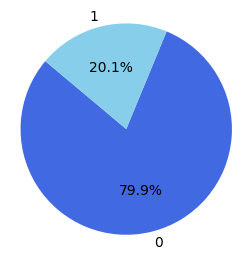

In [18]:
#Analisando a variável Churn
qualitativa(df_treino['Churn'])

<font color="yellow" size="4">A percentual de churn de 20,1% está acima dos padrões de marcado.</font>

TABELA DE FREQUÊNCIA
 
        Estado  frequencia_absoluta  frequencia_relativa  frequencia_acumulada
     São Paulo                 3493             0.499000              0.499000
  Minas Gerais                 1798             0.256857              0.755857
Rio de Janeiro                 1709             0.244143              1.000000
 
CONTAGEM DE VALORES NULOS/AUSENTES
0
 
GRÁFICO DE PIZZA


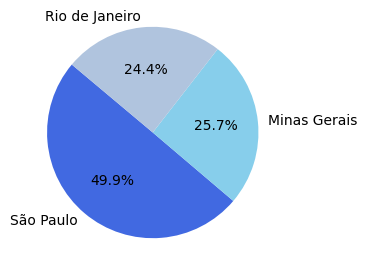

In [19]:
#Analisando a variável Estado
qualitativa(df_treino['Estado'])

TABELA DE FREQUÊNCIA
 
   Gênero  frequencia_absoluta  frequencia_relativa  frequencia_acumulada
Masculino                 3837             0.548143              0.548143
 Feminino                 3163             0.451857              1.000000
 
CONTAGEM DE VALORES NULOS/AUSENTES
0
 
GRÁFICO DE PIZZA


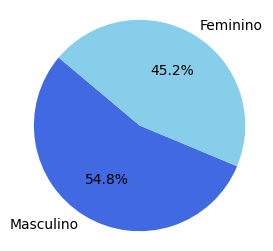

In [20]:
#Analisando a variável Gênero
qualitativa(df_treino['Gênero'])

TABELA DE FREQUÊNCIA
 
 Qte_Categorias  frequencia_absoluta  frequencia_relativa  frequencia_acumulada
              1                 3572             0.510286              0.510286
              2                 3199             0.457000              0.967286
              3                  184             0.026286              0.993571
              4                   45             0.006429              1.000000
 
CONTAGEM DE VALORES NULOS/AUSENTES
0
 
GRÁFICO DE BARRAS


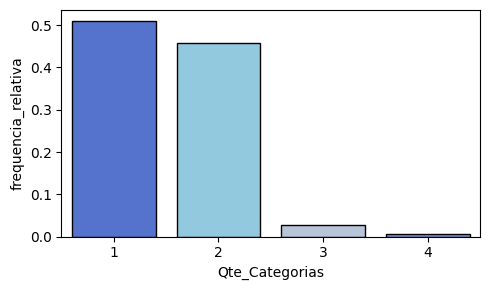

In [21]:
#Analisando a variável Qte_Categorias
qualitativa(df_treino['Qte_Categorias'])

<font color="yellow" size="4">Existe uma concentração de clientes que compraram até 2 categorias.</font>

TABELA DE FREQUÊNCIA
 
 Usa_Cartao_Credito  frequencia_absoluta  frequencia_relativa  frequencia_acumulada
                  1                 4962             0.708857              0.708857
                  0                 2038             0.291143              1.000000
 
CONTAGEM DE VALORES NULOS/AUSENTES
0
 
GRÁFICO DE PIZZA


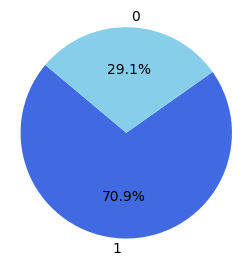

In [22]:
#Analisando a variável Usa_Cartao_Credito
qualitativa(df_treino['Usa_Cartao_Credito'])

TABELA DE FREQUÊNCIA
 
 Programa_Fidelidade  frequencia_absoluta  frequencia_relativa  frequencia_acumulada
                   1                 3646             0.520857              0.520857
                   0                 3354             0.479143              1.000000
 
CONTAGEM DE VALORES NULOS/AUSENTES
0
 
GRÁFICO DE PIZZA


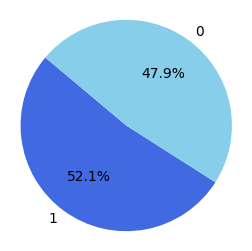

In [23]:
#Analisando a variável Programa_Fidelidade
qualitativa(df_treino['Programa_Fidelidade'])

MEDIDAS ESTATÍSTICAS

  count    7000.000000
mean       38.881571
std        10.487031
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Idade, dtype: float64

CONTAGEM DE VALORES NULOS/AUSENTES
  0

HISTOGRAMA E BOXPLOT


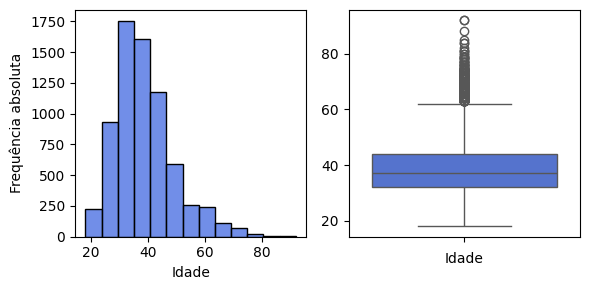

In [24]:
#Analisando a variável Idade
quantitativa(df_treino['Idade'])

<font color="yellow" size="4">75% da base possui até 44 anos, porém há muitos outliers.</font>

MEDIDAS ESTATÍSTICAS

  count    7000.000000
mean        4.961714
std         2.874668
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tempo_Cliente, dtype: float64

CONTAGEM DE VALORES NULOS/AUSENTES
  0

HISTOGRAMA E BOXPLOT


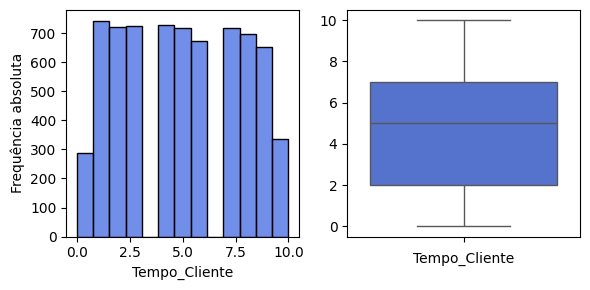

In [25]:
#Analisando a Tempo_Cliente
quantitativa(df_treino['Tempo_Cliente'])

MEDIDAS ESTATÍSTICAS

  count    7000.000000
mean      649.651429
std        96.629539
min       350.000000
25%       582.000000
50%       651.000000
75%       717.000000
max       850.000000
Name: Score_Credito, dtype: float64

CONTAGEM DE VALORES NULOS/AUSENTES
  0

HISTOGRAMA E BOXPLOT


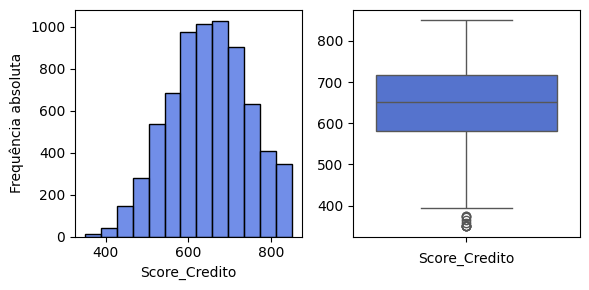

In [26]:
#Analisando a Score_Credito
quantitativa(df_treino['Score_Credito'])

MEDIDAS ESTATÍSTICAS

  count    7000.000000
mean      771.413823
std       621.183487
min         0.000000
25%         0.000000
50%       974.056050
75%      1278.232750
max      2508.980900
Name: Limite_Credito_Mercado, dtype: float64

CONTAGEM DE VALORES NULOS/AUSENTES
  0

HISTOGRAMA E BOXPLOT


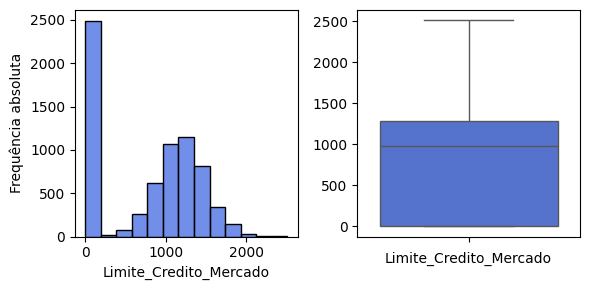

In [27]:
#Analisando a Limite_Credito_Mercado
quantitativa(df_treino['Limite_Credito_Mercado'])

<font color="yellow" size="4">Apesar da base possuir bom score(variável Score_Credito), até 25% da base não possui crédito no mercado, o que pode indicar uma inconsistência.</font>

MEDIDAS ESTATÍSTICAS

  count    7000.000000
mean      415.975420
std       240.150532
min         0.375292
25%       207.687583
50%       415.084812
75%       623.240042
max       833.211417
Name: Sum_Pedidos_Acumulados, dtype: float64

CONTAGEM DE VALORES NULOS/AUSENTES
  0

HISTOGRAMA E BOXPLOT


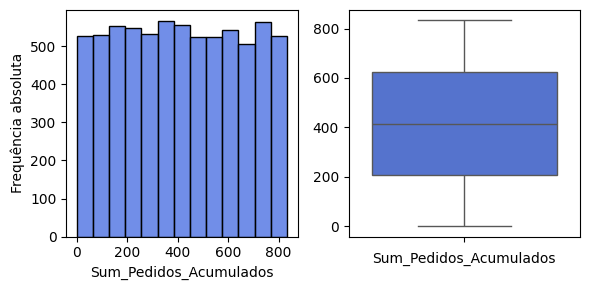

In [28]:
#Analisando a Sum_Pedidos_Acumulados
quantitativa(df_treino['Sum_Pedidos_Acumulados'])

##Bivariada

Churn              0    1  Taxa_Valor_Um      Odds        IV
Estado                                                      
São Paulo       2951  542       0.155167  0.728800  0.045284
Rio de Janeiro  1437  272       0.159157  0.751088  0.018312
Minas Gerais    1203  595       0.330923  1.962591  0.139653

O INFORMATION VALUE TOTAL É: 0.2
CLASSIFICADO COMO: MÉDIO


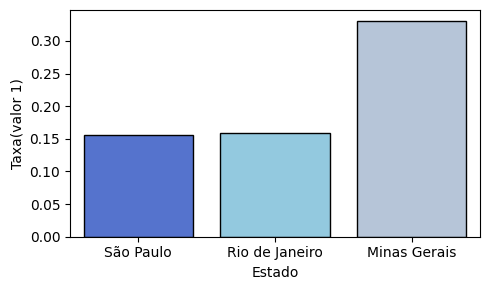

In [29]:
#Analisando associação entre Estado e Churn
Estado = tabela_iv(df_treino['Estado'],df_treino['Churn'])

<font color="yellow" size="4">O estado de Minas Gerais é o estado com a maior taxa de churn.</font>

Churn         0    1  Taxa_Valor_Um      Odds        IV
Gênero                                                 
Masculino  3221  616       0.160542  0.758872  0.038330
Feminino   2370  793       0.250711  1.327710  0.039376

O INFORMATION VALUE TOTAL É: 0.08
CLASSIFICADO COMO: FRACO


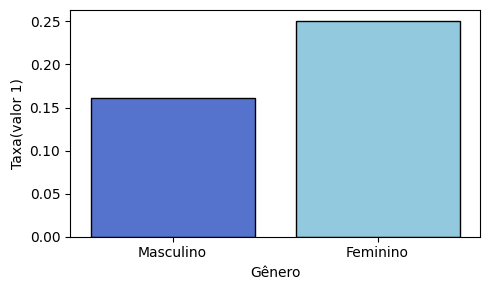

In [30]:
#Analisando associação entre Gênero e Churn
Genero = tabela_iv(df_treino['Gênero'],df_treino['Churn'])

Churn              0    1  Taxa_Valor_Um        Odds        IV
Qte_Categorias                                                
2               2969  230       0.071897    0.307395  0.433860
1               2591  981       0.274636    1.502381  0.094768
3                 30  154       0.836957   20.369387  0.313253
4                  1   44       0.977778  174.594748  0.160289

O INFORMATION VALUE TOTAL É: 1.0
CLASSIFICADO COMO: MUITO FORTE


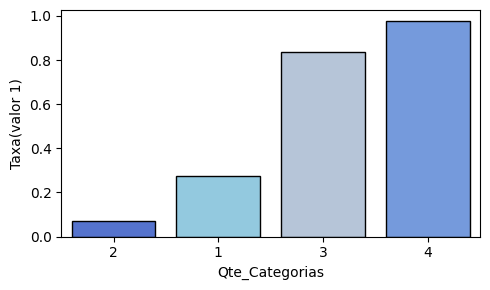

In [31]:
#Analisando associação entre Qte_Categorias e Churn
Qte_Categorias = tabela_iv(df_treino['Qte_Categorias'],df_treino['Churn'])

<font color="yellow" size="4">Clientes que compraram em 2 categorias possuem a menor taxa de churn(0,07%), em contrapartida, clientes que compraram acima de 2 categorias apresentaram uma taxa de churn muito superior. Uma hipótese levatada foi que algumas categorias podem estar sendo privilegiadas em relação as demais, por isso se faz necessário realizar uma análise mais apurada considerando também os tipos de categoria.</font>

Churn                  0    1  Taxa_Valor_Um      Odds        IV
Usa_Cartao_Credito                                              
1                   3966  996       0.200726  0.996518  0.000009
0                   1625  413       0.202650  1.008498  0.000021

O INFORMATION VALUE TOTAL É: 0.0
CLASSIFICADO COMO: MUITO FRACO


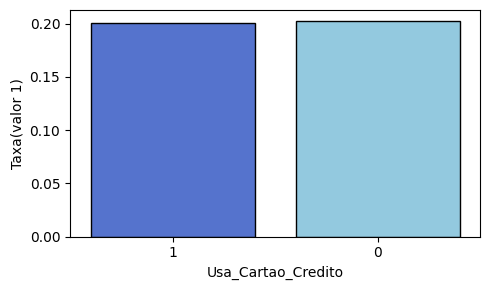

In [32]:
#Analisando associação entre Usa_Cartao_Credito e Churn
Usa_Cartao_Credito = tabela_iv(df_treino['Usa_Cartao_Credito'],df_treino['Churn'])

Churn                   0    1  Taxa_Valor_Um      Odds        IV
Programa_Fidelidade                                              
1                    3120  526       0.144268  0.668975  0.074261
0                    2471  883       0.263268  1.417968  0.064511

O INFORMATION VALUE TOTAL É: 0.14
CLASSIFICADO COMO: MÉDIO


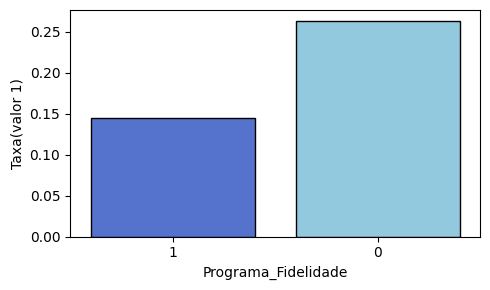

In [33]:
#Analisando associação entre Programa_Fidelidade e Churn
Programa_Fidelidade = tabela_iv(df_treino['Programa_Fidelidade'],df_treino['Churn'])

<font color="yellow" size="4">Programas de fidelidade podem ser um bom incentivo a reduzir a taxa de Churn visto, porém é necessário analisar o potencial financeiro desses programas.</font>

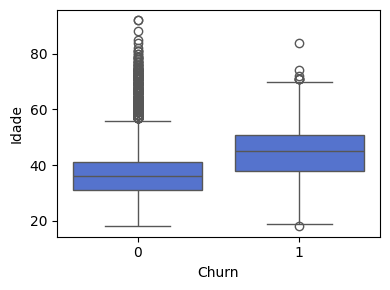

Churn                0    1  Taxa_Valor_Um      Odds        IV
Idade                                                         
(74.923, 80.615]    26    0       0.000000  0.000000  0.000000
(86.308, 92.0]       3    0       0.000000  0.000000  0.000000
(17.926, 23.692]   206   17       0.076233  0.327461  0.027664
(23.692, 29.385]   862   72       0.077088  0.331439  0.113828
(29.385, 35.077]  1597  157       0.089510  0.390098  0.163995
(69.231, 74.923]    63    9       0.125000  0.566866  0.002770
(80.615, 86.308]     6    1       0.142857  0.661344  0.000150
(35.077, 40.769]  1371  236       0.146857  0.683051  0.029626
(63.538, 69.231]    83   30       0.265487  1.434239  0.002325
(40.769, 46.462]   843  332       0.282553  1.562748  0.037881
(57.846, 63.538]   134  106       0.441667  3.138915  0.058639
(46.462, 52.154]   294  294       0.500000  3.968062  0.215114
(52.154, 57.846]   103  155       0.600775  5.971356  0.163659

O INFORMATION VALUE TOTAL É: 0.82
CLASSIFICADO COMO: M

In [34]:
#Analisando associação entre Idade e Churn
Idade = tabela_iv(df_treino['Idade'],df_treino['Churn'])

<font color="yellow" size="4">A idade possui forte poder de classificação quanto ao Churn. Clientes até 39 anos apresentam uma taxa de churn aceitável, porém a medida que a idade aumenta, a taxa também aumenta, ao ponto que clientes na faixa de 52 a 57 anos apresentam uma taxa de 58%, ou seja mais da metade dão Churn. Esse comportamento diminui quando a idade já é mais avançada, porém como há outliers é necessário análisar essa relação os excluindo.</font>

Churn            0    1  Taxa_Valor_Um      Odds        IV
Tempo_Cliente                                             
7              586  132       0.183844  0.893830  0.001249
8              568  128       0.183908  0.894211  0.001202
2              590  133       0.183956  0.894495  0.001241
3              586  140       0.192837  0.948001  0.000291
6              542  130       0.193452  0.951749  0.000231
10             269   66       0.197015  0.973577  0.000034
4              577  150       0.206327  1.031559  0.000101
1              586  157       0.211306  1.063116  0.000405
5              565  154       0.214186  1.081560  0.000646
9              508  146       0.223242  1.140427  0.001677
0              214   73       0.254355  1.353591  0.004098

O INFORMATION VALUE TOTAL É: 0.01
CLASSIFICADO COMO: MUITO FRACO


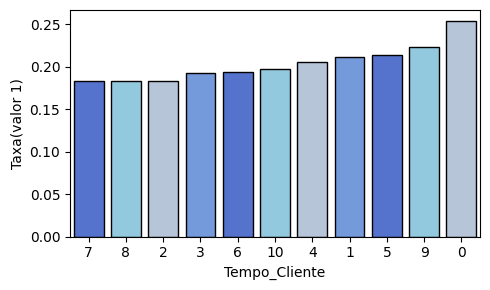

In [35]:
#Analisando associação entre Tempo_Cliente e Churn
Tempo_Cliente = tabela_iv(df_treino['Tempo_Cliente'],df_treino['Churn'])

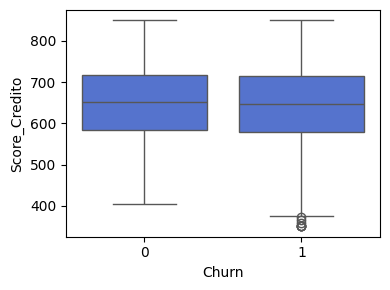

Churn                 0    1  Taxa_Valor_Um      Odds        IV
Score_Credito                                                  
(811.538, 850.0]    283   64       0.184438  0.897371  0.000563
(657.692, 696.154]  838  190       0.184825  0.899680  0.001590
(773.077, 811.538]  330   76       0.187192  0.913857  0.000458
(465.385, 503.846]  224   53       0.191336  0.938872  0.000154
(696.154, 734.615]  729  175       0.193584  0.952553  0.000301
(580.769, 619.231]  782  192       0.197125  0.974256  0.000094
(619.231, 657.692]  804  210       0.207101  1.036434  0.000187
(426.923, 465.385]  114   30       0.208333  1.044227  0.000039
(388.462, 426.923]   34    9       0.209302  1.050369  0.000015
(542.308, 580.769]  541  145       0.211370  1.063529  0.000379
(503.846, 542.308]  422  115       0.214153  1.081344  0.000480
(734.615, 773.077]  490  140       0.222222  1.133732  0.001471
(349.5, 388.462]      0   10       1.000000       inf  0.000000

O INFORMATION VALUE TOTAL É: 0.01
CLASS

In [36]:
#Analisando associação entre Score_Credito e Churn
Score_Credito = tabela_iv(df_treino['Score_Credito'],df_treino['Churn'])

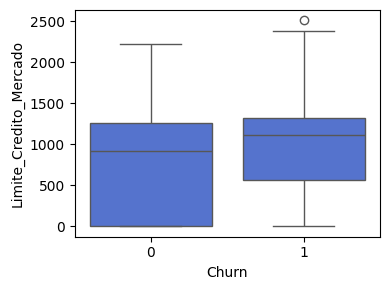

Churn                      0    1  Taxa_Valor_Um      Odds        IV
Limite_Credito_Mercado                                              
(-2.509, 192.999]       2158  331       0.132985  0.608632  0.075007
(578.996, 771.994]       209   46       0.180392  0.873353  0.000641
(771.994, 964.993]       503  115       0.186084  0.907211  0.000813
(1543.988, 1736.987]     270   75       0.217391  1.102240  0.000481
(1350.99, 1543.988]      629  181       0.223457  1.141843  0.002117
(1736.987, 1929.985]     108   34       0.239437  1.249205  0.001071
(964.993, 1157.991]      804  264       0.247191  1.302946  0.011528
(1157.991, 1350.99]      832  319       0.277150  1.521409  0.032560
(385.997, 578.996]        51   21       0.291667  1.633908  0.002839
(2122.984, 2315.982]       4    2       0.333333  1.984031  0.000482
(192.999, 385.997]         9    5       0.357143  2.204479  0.001533
(1929.985, 2122.984]      14   14       0.500000  3.968062  0.010244
(2315.982, 2508.981]       0    2 

In [37]:
#Analisando associação entre Limite_Credito_Mercado e Churn
Limite_Credito_Mercado = tabela_iv(df_treino['Limite_Credito_Mercado'],df_treino['Churn'])

<font color="yellow" size="4">Usuários com maior limite de crédito apresentam uma leve tendência em dar Churn</font>

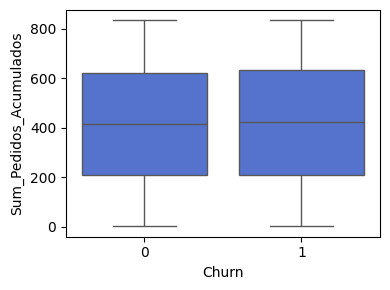

Churn                     0    1  Taxa_Valor_Um      Odds        IV
Sum_Pedidos_Acumulados                                             
(384.761, 448.826]      456   99       0.178378  0.861487  0.001684
(320.697, 384.761]      462  105       0.185185  0.901832  0.000838
(256.633, 320.697]      430  101       0.190207  0.932033  0.000368
(512.89, 576.954]       423  101       0.192748  0.947457  0.000215
(64.44, 128.504]        427  102       0.192817  0.947874  0.000213
(128.504, 192.568]      445  107       0.193841  0.954118  0.000172
(769.147, 833.211]      420  107       0.203036  1.010911  0.000009
(-0.458, 64.44]         420  108       0.204545  1.020359  0.000031
(448.826, 512.89]       416  109       0.207619  1.039709  0.000115
(641.018, 705.083]      398  107       0.211881  1.066791  0.000307
(576.954, 641.018]      428  116       0.213235  1.075456  0.000420
(705.083, 769.147]      439  125       0.221631  1.129858  0.001245
(192.568, 256.633]      427  122       0.222222 

In [38]:
#Analisando associação entre Sum_Pedidos_Acumulados e Churn
Sum_Pedidos_Acumulados = tabela_iv(df_treino['Sum_Pedidos_Acumulados'],df_treino['Churn'])

#Preparação dos dados

##Separando as bases em X e y

In [39]:
#Fazendo uma cópia do df para iniciar a preparação dos dados
df_treino_prep = df_treino.copy()
df_teste_prep = df_teste.copy()

In [40]:
#Separando em variável explicativa e resposta
X = df_treino_prep.drop(['Churn','ClientId'], axis=1)
y = df_treino_prep['Churn']
X_teste = df_teste_prep.drop(['Churn','ClientId'], axis=1)
y_teste = df_teste_prep['Churn']

In [41]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 7000 entries, 0 to 6999
Series name: Churn
Non-Null Count  Dtype
--------------  -----
7000 non-null   int64
dtypes: int64(1)
memory usage: 54.8 KB


##Tratando variáveis categóricas

In [42]:
#Alterando o tipo da variável Qte_categorias para ela se tornar dummie
X['Qte_Categorias'] = X['Qte_Categorias'].astype(str)
X_teste['Qte_Categorias'] = X_teste['Qte_Categorias'].astype(str)
#Codificando para adequar ao processamento do modelo
X = pd.get_dummies(X, drop_first=True)
X_teste = pd.get_dummies(X_teste, drop_first=True)

##Selecionando variáveis

In [43]:
#Selecionando com base no p-valor(Eliminação Stepwise)
model = sm.Logit(y, X)
result = model.fit()
result.pvalues.apply(lambda x: f"{x:.3f}")

Optimization terminated successfully.
         Current function value: 0.367567
         Iterations 8


Score_Credito             0.000
Idade                     0.000
Tempo_Cliente             0.018
Limite_Credito_Mercado    0.026
Usa_Cartao_Credito        0.074
Programa_Fidelidade       0.000
Sum_Pedidos_Acumulados    0.225
Estado_Rio de Janeiro     0.000
Estado_São Paulo          0.000
Gênero_Masculino          0.000
Qte_Categorias_2          0.000
Qte_Categorias_3          0.000
Qte_Categorias_4          0.000
dtype: object

In [44]:
#Excluindo as variáveis com p-valor alto
X = X.drop(['Sum_Pedidos_Acumulados','Usa_Cartao_Credito','Limite_Credito_Mercado'], axis=1)
#Rodando novamente o modelo
model = sm.Logit(y, X)
result = model.fit()
result.pvalues.apply(lambda x: f"{x:.3f}")

Optimization terminated successfully.
         Current function value: 0.368312
         Iterations 8


Score_Credito            0.000
Idade                    0.000
Tempo_Cliente            0.007
Programa_Fidelidade      0.000
Estado_Rio de Janeiro    0.000
Estado_São Paulo         0.000
Gênero_Masculino         0.000
Qte_Categorias_2         0.000
Qte_Categorias_3         0.000
Qte_Categorias_4         0.000
dtype: object

In [45]:
#Aplicando a transformação na base teste
X_teste = X_teste.drop(['Sum_Pedidos_Acumulados','Usa_Cartao_Credito','Limite_Credito_Mercado'], axis=1)

##Tratamento de outliers

In [46]:
#Encontrando os outliers da variável Idade
indices_outliers = outliers(X['Idade'],y)
#Excluindo os outliers
X = X.drop(indices_outliers)
y = y.drop(indices_outliers)
#Organizando os índices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

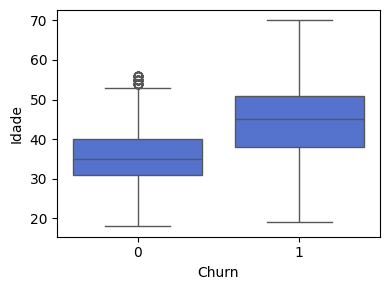

Churn              0    1  Taxa_Valor_Um       Odds        IV
Idade                                                        
(22.0, 26.0]     388   27       0.065060   0.260817  0.073404
(17.948, 22.0]   144   12       0.076923   0.312336  0.021945
(26.0, 30.0]     749   64       0.078721   0.320260  0.110398
(30.0, 34.0]    1090   98       0.082492   0.336979  0.149704
(34.0, 38.0]    1178  164       0.122206   0.521798  0.069782
(38.0, 42.0]     870  216       0.198895   0.930547  0.000828
(42.0, 46.0]     460  232       0.335260   1.890314  0.049662
(46.0, 50.0]     230  217       0.485459   3.536192  0.140310
(50.0, 54.0]     106  141       0.570850   4.985597  0.129256
(54.0, 58.0]      36  109       0.751724  11.348223  0.172332
(58.0, 62.0]       0   75       1.000000        inf  0.000000
(62.0, 66.0]       0   32       1.000000        inf  0.000000
(66.0, 70.0]       0   14       1.000000        inf  0.000000

O INFORMATION VALUE TOTAL É: 0.92
CLASSIFICADO COMO: MUITO FORTE


Churn,Idade,0,1,Taxa_Valor_Um,Odds,IV
0,"(22.0, 26.0]",388,27,0.065060,0.260817,0.073404
1,"(17.948, 22.0]",144,12,0.076923,0.312336,0.021945
2,"(26.0, 30.0]",749,64,0.078721,0.320260,0.110398
3,"(30.0, 34.0]",1090,98,0.082492,0.336979,0.149704
4,"(34.0, 38.0]",1178,164,0.122206,0.521798,0.069782
5,"(38.0, 42.0]",870,216,0.198895,0.930547,0.000828
6,"(42.0, 46.0]",460,232,0.335260,1.890314,0.049662
7,"(46.0, 50.0]",230,217,0.485459,3.536192,0.140310
8,"(50.0, 54.0]",106,141,0.570850,4.985597,0.129256
9,"(54.0, 58.0]",36,109,0.751724,11.348223,0.172332


In [47]:
#Verificando o novo IV
tabela_iv(X['Idade'],y)

<font color="yellow" size="4">O IV aumentou de 0.81 para 0.92 e ficou claro a forte tendência de Churn em clientes com idade mais avançada. Nas faixas a partir de 58 anos, todos clientes deram Churn.</font>

##Escalonamento(Min-Max Scaling)

In [48]:
# Inicializar o scaler
scaler = MinMaxScaler()
# Treinar o scaler aos dados
colunas = ['Score_Credito', 'Idade', 'Tempo_Cliente']
scaler.fit(X[colunas])
# Aplicar em ambas bases
X[colunas] = scaler.transform(X[colunas])
X_teste[colunas] = scaler.transform(X_teste[colunas])

##Balanceamento(undersampler)

In [50]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X, y = undersampler.fit_resample(X, y)

#Modelagem

##Treinando o modelo

In [51]:
# Instanciando e configurando o modelo de regressão logística
modelo_regressao = LogisticRegression(random_state=42)

# Treinando o modelo
modelo_regressao.fit(X, y)

LogisticRegression(random_state=42)

In [52]:
#Medindo a performance utilizando AUC

#Obtendo as probabilidades
y_proba = modelo_regressao.predict_proba(X)[:, 1]

# Calcula a área abaixo da curva ROC
auc = roc_auc_score(y, y_proba)

print(f'AUC da regressão logística: {auc:.2f}')

AUC da regressão logística: 0.87


<font color="yellow">A métrica utilziada será o AUC, pois é a mais indicada quando trata-se de uma base desbalanceada.</font>

##Validação

In [53]:
#Criando 5 dobras estratificadas
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista para armazenar os resultados
treino_aucs = []
validacao_aucs = []

# Realizando a validação cruzada estratificada
for treino_index, validacao_index in stratified_kfold.split(X, y):
    X_treino, X_validacao = X.iloc[treino_index], X.iloc[validacao_index]
    y_treino, y_validacao = y.iloc[treino_index], y.iloc[validacao_index]

    modelo_regressao.fit(X_treino, y_treino)

    y_train_pred = modelo_regressao.predict_proba(X_treino)[:, 1]
    y_validacao_pred = modelo_regressao.predict_proba(X_validacao)[:, 1]

    train_auc = roc_auc_score(y_treino, y_train_pred)
    validation_auc = roc_auc_score(y_validacao, y_validacao_pred)

    treino_aucs.append(train_auc)
    validacao_aucs.append(validation_auc)

#Calculando a média e desvio padrão
mean_train_auc = np.mean(treino_aucs)
mean_validation_auc = np.mean(validacao_aucs)
std_train_auc = np.std(treino_aucs)
std_validation_auc = np.std(validacao_aucs)

# Exibindo os resultados
for i, (treino_auc, validacao_auc) in enumerate(zip(treino_aucs, validacao_aucs), 1):
    print(f"Fold {i}: AUC (Treino) = {treino_auc:.4f}, AUC (Validação) = {validacao_auc:.4f}")

print(20*'-=')

print(f'Média AUC Treino: {mean_train_auc:.4f}')
print(f'Média AUC Validação: {mean_validation_auc:.4f}')
print(f'Desvio AUC Treino: {std_train_auc:.4f}')
print(f'Desvio AUC Validação: {std_validation_auc:.4f}')

Fold 1: AUC (Treino) = 0.8650, AUC (Validação) = 0.9036
Fold 2: AUC (Treino) = 0.8782, AUC (Validação) = 0.8500
Fold 3: AUC (Treino) = 0.8712, AUC (Validação) = 0.8790
Fold 4: AUC (Treino) = 0.8741, AUC (Validação) = 0.8678
Fold 5: AUC (Treino) = 0.8767, AUC (Validação) = 0.8585
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Média AUC Treino: 0.8731
Média AUC Validação: 0.8718
Desvio AUC Treino: 0.0047
Desvio AUC Validação: 0.0186


<font color="yellow">Modelo consistente tanto na média quanto no desvio padrão dos AUC.</font>

In [54]:
# Instanciando e treinando o modelo final
modelo_final = LogisticRegression(random_state=42)
modelo_final.fit(X, y)

LogisticRegression(random_state=42)

In [55]:
#Testando na base de teste
prob_teste = modelo_final.predict_proba(X_teste)[:,1]
roc_teste = roc_auc_score(y_teste, prob_teste)
print(f'AUC na base Teste: {roc_teste}')

AUC na base Teste: 0.8150788013134472


<font color="yellow">AUC final ficou em 0.81,5</font>

#Medindo o impacto financeiro

In [56]:
#Definindo as variáveis para o cálculo financeiro(vide premissas)
ltv = 419
cac = 150
cupom = 100

In [57]:
# Criando a função para calcular o lucro
def calcular_lucro(y_test, y_probs, threshold):
    y_pred = np.where(y_probs >= threshold, 1, 0)
    cm = confusion_matrix(y_test, y_pred)

    vn = cm[0,0] * (ltv - cac)
    fn = cm[1,0] * cac
    vp = cm[1,1] * (ltv-cac-cupom)
    fp = cm[0,1] * (ltv-cac-cupom)

    lucro_total = vn + vp + fp - fn

    return lucro_total

In [58]:
# Criando a função para encontrar o threshold ótimo
def encontrar_threshold_otimo(modelo, X_test, y_test):
    y_probs = modelo.predict_proba(X_test)[:, 1]

    thresholds = np.linspace(0, 1, 1000)
    lucros = []

    for threshold in thresholds:
        lucro = calcular_lucro(y_test, y_probs, threshold)
        lucros.append(lucro)

    threshold_otimo = thresholds[np.argmax(lucros)]

    return threshold_otimo

<font color="yellow">A intenção da função acima é otimizar o tempo, de forma que encontre automaticamente o threshold ótimo, que faça o modelo trabalhar para trazer o maior retorno financeiro.</font>

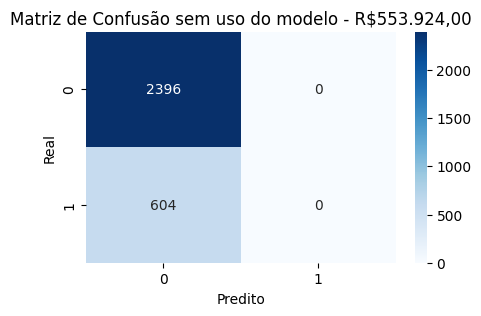

In [71]:
#Plotando a matriz de confusão considerando que ninguém dará churn(cenário atual), ou seja, não há modelo
y_predito_prob = modelo_final.predict_proba(X_teste)[:, 1]
y_predito = np.where(y_predito_prob >= 1.0, 1, 0)

# Calculando a matriz de confusão
cm = confusion_matrix(y_teste, y_predito)

#Plotando
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão sem uso do modelo - R$553.924,00')
plt.show()

In [60]:
#Calculando o resultado financeiro atual, sem o uso do modelo
receita_sem_modelo = calcular_lucro(y_teste, modelo_final.predict_proba(X_teste)[:, 1],1.0) #por o threshold em 100% equivale a não ter modelo
receita_sem_modelo

553924

<font color="yellow">O resultado da empresa no período de 4 meses, sem o uso do modelo e sem o uso de qualquer regra, considerando 3000 clientes, foi de 553924 reais.</font>

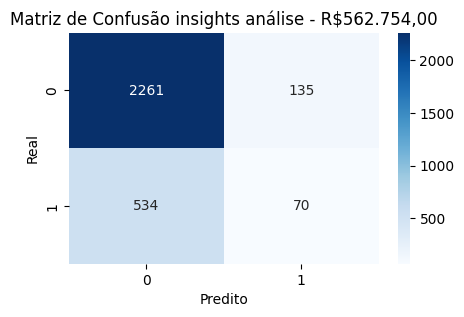

In [80]:
#Calculando a matriz de confusão utilizando os insights da análise exploratória
#clientes com idade superior a 58 anos e 4 categorias compradas
y_predito = [1 if categoria >= 4 or idade >= 58 else 0 for categoria, idade in zip(df_teste['Qte_Categorias'], df_teste['Idade'])]

# Calculando a matriz de confusão
cm = confusion_matrix(y_teste, y_predito)

#Plotando
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão insights análise - R$562.754,00')
plt.show()

In [81]:
#Calculando o resultado financeiro utilizando somente a regra de idade e quantidade categorias
vn = cm[0,0] * (ltv - cac)
fn = cm[1,0] * cac
vp = cm[1,1] * (ltv-cac-cupom)
fp = cm[0,1] * (ltv-cac-cupom)

receita_analise = vn + vp + fp - fn
receita_analise - receita_sem_modelo

8830

<font color="yellow">Considerando as mesmas condições, se fossem criadas regras baseadas na análise exploratória, na qual foi constatada a alta probabilidade de churn entre clientes com mais idade e clientes que compraram em 4 categorias, o ganho seria de 8830 reais em comparação ao resultado financeiro atual.</font>

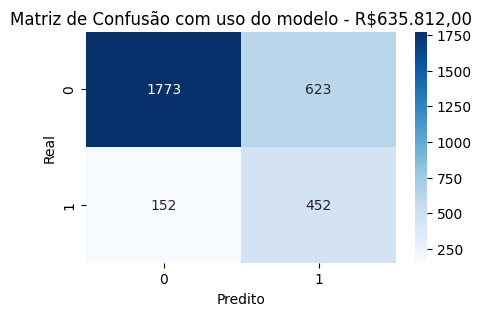

In [72]:
# Calculando a matriz de confusão utilizando o modelo com threshold em 50%(padrão)
cm = confusion_matrix(y_teste, modelo_final.predict(X_teste))

#Plotando
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão com uso do modelo - R$635.812,00')
plt.show()

In [73]:
#Calculando o resultado financeiro que o modelo traria utilizando o threshold padrão(50%)
receita_modelo_padrao = calcular_lucro(y_teste, modelo_final.predict_proba(X_teste)[:, 1],0.5)
receita_modelo_padrao - receita_sem_modelo #diferença entre resultado com modelo e resultado sem modelo

81888

<font color="yellow">Considerando as mesmas condições, se o modelo estivesse em produção, utilizando o threshold padrão(50%), a empresa teria um ganho de 81888 reais em comparação ao resultado financeiro atual.</font>

In [65]:
# Encontrando o threshold ótimo
encontrar_threshold_otimo(modelo_final,X_teste,y_teste)

0.5405405405405406

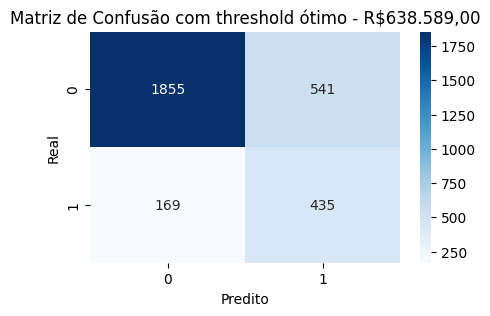

In [78]:
# Calculando a matriz de confusão do modelo final com threshold ótimo(54%)
y_predito_prob = modelo_final.predict_proba(X_teste)[:, 1]
y_predito = np.where(y_predito_prob >= 0.54, 1, 0)

# Calculando a matriz de confusão
cm = confusion_matrix(y_teste, y_predito)

#Plotando
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão com threshold ótimo - R$638.589,00')
plt.show()

In [77]:
# Claculando o resultado financeiro que o modelo traria utilizando o threshold ótimo(54%)
receita_modelo_otimo = calcular_lucro(y_teste, modelo_final.predict_proba(X_teste)[:, 1],0.54)
receita_modelo_otimo - receita_sem_modelo #diferença entre resultado com modelo(threshold ótimo) e resultado sem modelo

638589

<font color="yellow">Considerando as mesmas condições, se o modelo estivesse em produção, utilizando o threshold Ótimo(54%), a empresa teria um ganho de 84665 reais em comparação ao resultado financeiro atual. Esse valor representa uma diferença positiva de 2777 reais em comparação ao modelo com threshold padrão. </font>